In [1]:
# pip install imbalanced-learn

from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-07-08 11:27:57.055532: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 11:27:59.099021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 11:28:02.750390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
import numpy as np
import rasterio
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_dataset(data_dir, img_size=(256, 256)):
    """
    Load dataset from specified directory.

    Parameters:
    - data_dir (str): Directory containing train, val, and test subdirectories.
    - img_size (tuple): Desired size of the image (height, width).

    Returns:
    - train_data (tuple): Tuple containing (X_train, y_train).
    - val_data (tuple): Tuple containing (X_val, y_val).
    - test_data (tuple): Tuple containing (X_test, y_test).
    """
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')

    # Load training data
    X_train, y_train = load_data_from_dir(os.path.join(train_dir, 'input'), os.path.join(train_dir, 'output'), img_size)
    # Load validation data
    X_val, y_val = load_data_from_dir(os.path.join(val_dir, 'input'), os.path.join(val_dir, 'output'), img_size)
    # Load test data
    X_test, y_test = load_data_from_dir(os.path.join(test_dir, 'input'), os.path.join(test_dir, 'output'), img_size)

    # Preprocess to handle NaN values
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def preprocess_data(images):
    """
    Preprocesses input images to handle NaN values.

    Parameters:
    - images (numpy.ndarray): Array of input images.

    Returns:
    - images (numpy.ndarray): Processed array of input images.
    """
    # Replace NaN values with 0
    images[np.isnan(images)] = 0

    return images

def load_data_from_dir(input_dir, output_dir, img_size):
    """
    Load data (images and labels) from input and output directories.

    Parameters:
    - input_dir (str): Directory containing input images.
    - output_dir (str): Directory containing output images.
    - img_size (tuple): Desired size of the image (height, width).

    Returns:
    - images (numpy.ndarray): Array of loaded input images.
    - labels (numpy.ndarray): Array of corresponding output images.
    """
    images = []
    labels = []

    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            # Load input image (X)
            input_path = os.path.join(input_dir, filename)
            img = load_tiff_image(input_path, img_size)
            images.append(img)

            # Load corresponding output image (y)
            output_filename = filename.replace('.tif', '_cl.tif')
            output_path = os.path.join(output_dir, output_filename)
            label = load_tiff_image(output_path, img_size, is_label=True)
            label[np.isnan(label)] = 0 
            labels.append(label)

    if images and labels:
        images = np.array(images)
        labels = np.array(labels)

    return images, labels

def load_tiff_image(path, img_size, is_label=False):
    """
    Load a TIFF image from specified path.

    Parameters:
    - path (str): Path to the TIFF image.
    - img_size (tuple): Desired size of the image (height, width).
    - is_label (bool): Whether the image is a label image.

    Returns:
    - img (numpy.ndarray): Loaded image as a numpy array.
    """
    with rasterio.open(path) as src:
        img = src.read()

    # Reshape and resize if necessary
    img = img.transpose(1, 2, 0)  # Change from bands x height x width to height x width x bands
    img = img[:img_size[0], :img_size[1], :]  # Resize to desired size

    if is_label:
        # Convert label image to binary classification (1 for Marine Debris, 0 for others)
        img = (img == 1).astype(np.uint8)  # Assuming Marine Debris class is encoded as 1

    return img

# Example usage:
data_dir = 'MARIDA'
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_dataset(data_dir)

print(f"Training data: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Validation data: X_val shape = {X_val.shape}, y_val shape = {y_val.shape}")
print(f"Testing data: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")


Training data: X_train shape = (694, 256, 256, 11), y_train shape = (694, 256, 256, 1)
Validation data: X_val shape = (328, 256, 256, 11), y_val shape = (328, 256, 256, 1)
Testing data: X_test shape = (359, 256, 256, 11), y_test shape = (359, 256, 256, 1)


In [3]:
X_train.shape

(694, 256, 256, 11)

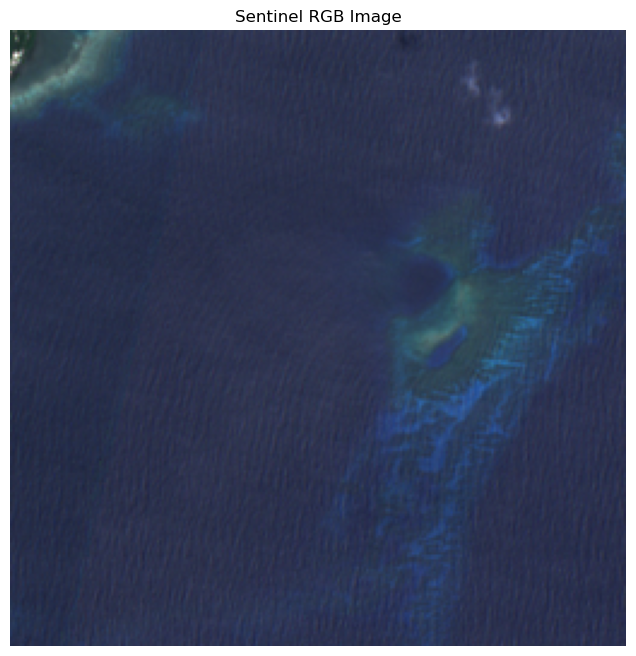

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a specific index for visualization (adjust as needed)
index = 5  # Change this index to visualize different images

# Select RGB bands (adjust bands as per your dataset)
red_band = X_train[index, ..., 3]  # Replace 3 with the correct index for red band
green_band = X_train[index, ..., 2]  # Replace 2 with the correct index for green band
blue_band = X_train[index, ..., 1]  # Replace 1 with the correct index for blue band

# Normalize bands to 0-1 range
# red_band = (red_band - np.min(red_band)) / (np.max(red_band) - np.min(red_band))
# green_band = (green_band - np.min(green_band)) / (np.max(green_band) - np.min(green_band))
# blue_band = (blue_band - np.min(blue_band)) / (np.max(blue_band) - np.min(blue_band))
red_band = (red_band ) / (np.max(red_band))
green_band = (green_band ) / (np.max(green_band))
blue_band = (blue_band ) / (np.max(blue_band))

# Stack the bands to create an RGB image
rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

# Display the RGB image
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)
plt.axis('off')
plt.title('Sentinel RGB Image')
plt.show()


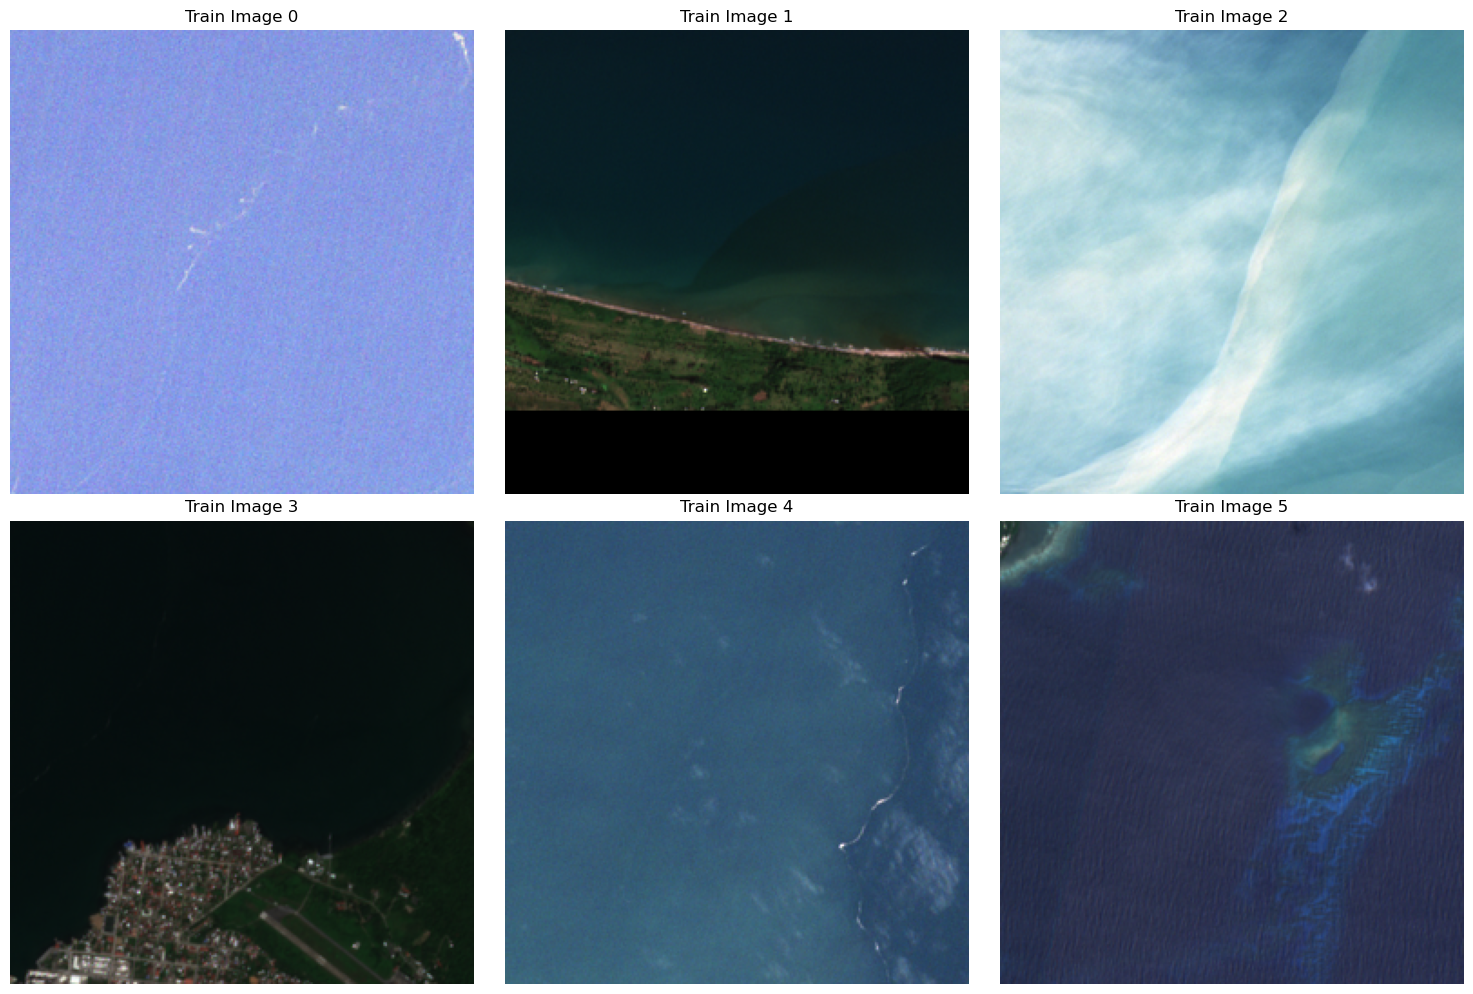

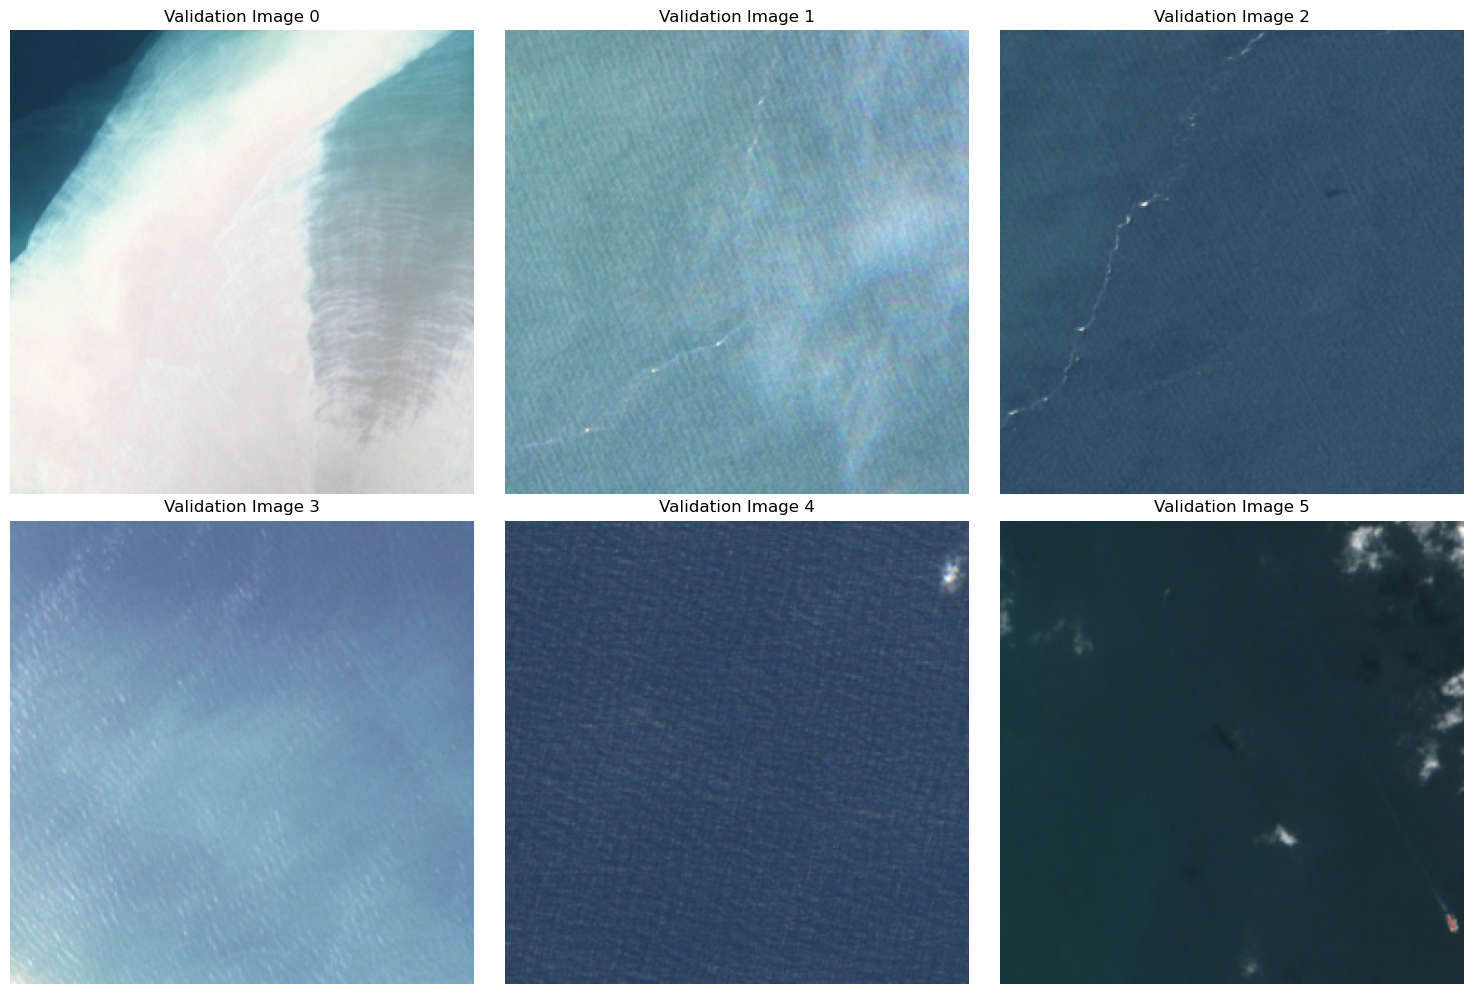

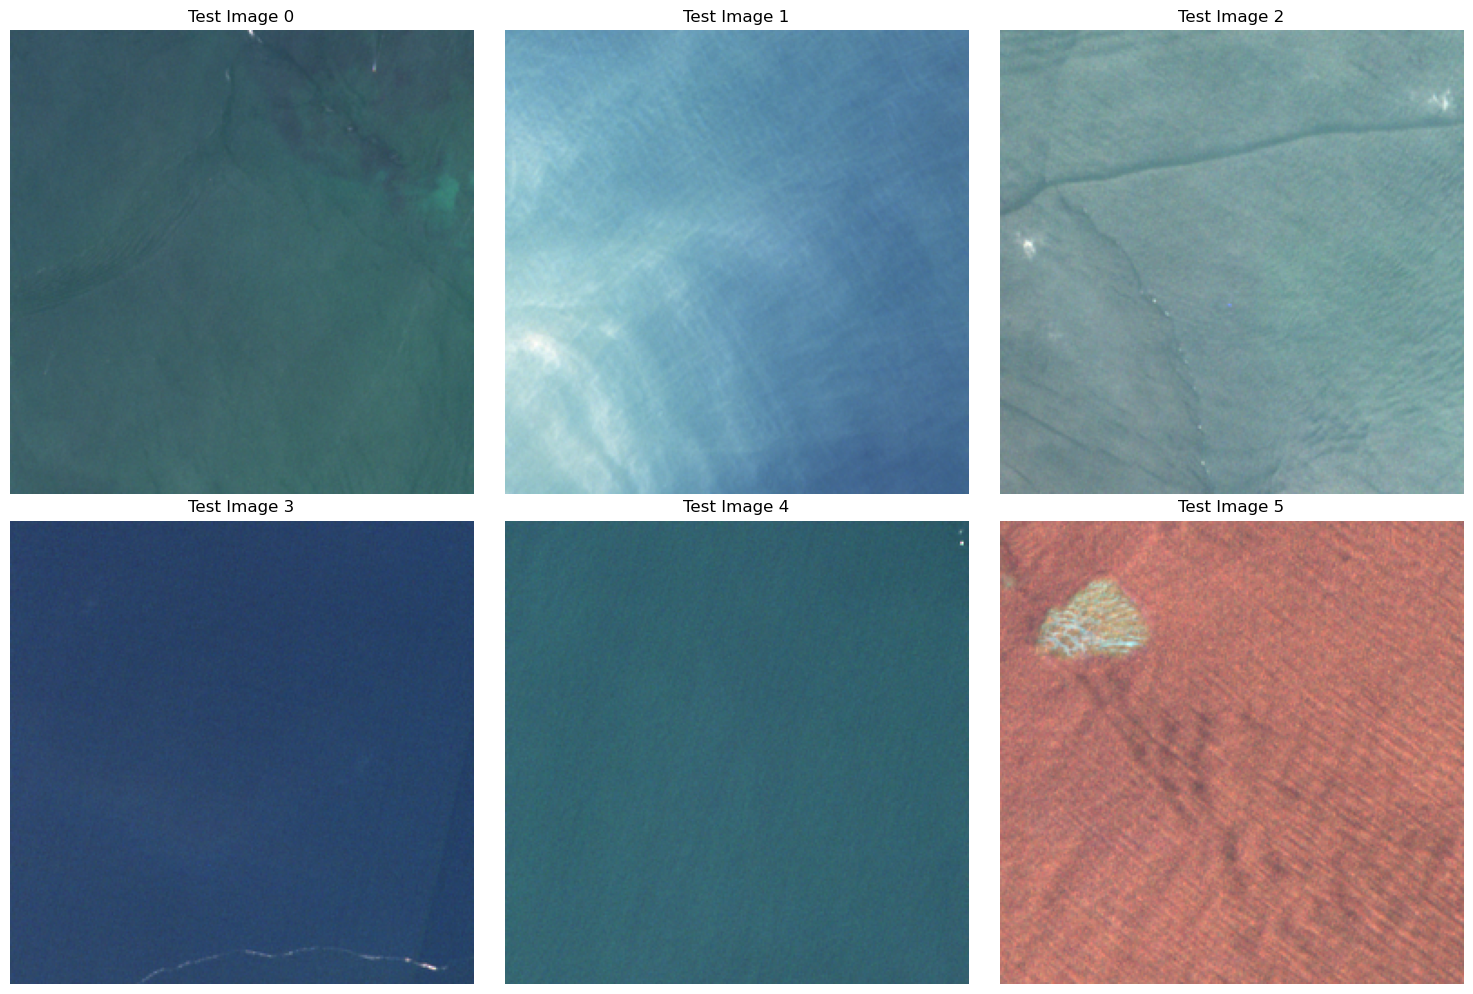

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create RGB image from bands
def create_rgb_image(index, dataset):
    red_band = dataset[index, ..., 3]  # Replace 3 with the correct index for red band
    green_band = dataset[index, ..., 2]  # Replace 2 with the correct index for green band
    blue_band = dataset[index, ..., 1]  # Replace 1 with the correct index for blue band
    
    # Normalize bands to 0-1 range
    # red_band = (red_band - np.min(red_band)) / (np.max(red_band) - np.min(red_band))
    # green_band = (green_band - np.min(green_band)) / (np.max(green_band) - np.min(green_band))
    # blue_band = (blue_band - np.min(blue_band)) / (np.max(blue_band) - np.min(blue_band))
    red_band = (red_band ) / (np.max(red_band))
    green_band = (green_band ) / (np.max(green_band))
    blue_band = (blue_band ) / (np.max(blue_band))
    # Stack the bands to create an RGB image
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)
    
    return rgb_image

# Visualize all images in X_train
plt.figure(figsize=(15, 10))
num_images = 6  # Number of images to display
for i in range(num_images):
    plt.subplot(2, 3, i + 1)
    rgb_image = create_rgb_image(i, X_train)
    plt.imshow(rgb_image)
    plt.title(f'Train Image {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Visualize all images in X_val
plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(2, 3, i + 1)
    rgb_image = create_rgb_image(i, X_val)
    plt.imshow(rgb_image)
    plt.title(f'Validation Image {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Visualize all images in X_test
plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(2, 3, i + 1)
    rgb_image = create_rgb_image(i, X_test)
    plt.imshow(rgb_image)
    plt.title(f'Test Image {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Image format: TIFF
Image mode: F
Image size: (256, 256)
Number of pixels: 65536
First 10 pixel values:
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0